In [1]:
import os
os.environ['YT_DEST'] = '/home/kwoksun2/anaconda2/pkgs/yt-3.3.5-np111py27_2/'
import numpy as np
from dengo.chemical_network import \
    ChemicalNetwork, \
    reaction_registry, \
    cooling_registry, species_registry
    
import sys
sys.path.append("cvdls_examples/9species_cooling")
sys.path.append("cvspils_examples/9species_cooling")
sys.path.append("be_chem_solve_examples/9species_cooling/")
import dengo.primordial_rates, dengo.primordial_cooling
from dengo.chemistry_constants import tiny, kboltz, mh
import yt
import yt.units as u
import numpy
import pickle
import pyximport
import h5py
import timeit
import time
from generate_dls_cooling_network import create_cvdls_solver, Init_values
import matplotlib.pyplot as plt
from sympy import lambdify

 using cli
 using CLI for selections


In [2]:
import os, sys

class HidePrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout = self._original_stdout

# Evolve Free Fall Parcel

1. let the gas cool at constant density from the starting temperature down to a lower temperature to get the species fractions in a resonable state
2. evolve density and temperature according to freefall collapse

In [3]:
init, primordial = Init_values(np.array([2000.0]), np.array([1e10]), 
                               n_species = 9, cooling=True)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [4]:
def calculate_pressure(init, primordial):
    P = numpy.zeros((1))
    T = init['T']
    for sp in primordial.required_species:
        if sp.name != 'ge':
            n_sp = init[sp.name]/sp.weight
            P += n_sp * u.boltzmann_constant_cgs.v * T
    return P

def calculate_collapse_factor(pressure, density):
    # Calculate the effective adiabatic index, dlog(p)/dlog(rho).
    if len(pressure) < 3:
        return 0.

    # compute dlog(p) / dlog(rho) using last two timesteps
    gamma_eff = np.log10(pressure[-1] / pressure[-2]) / \
        np.log10(density[-1] / density[-2])
    
    # compute a higher order derivative if more than two points available
    if len(pressure) > 2:
        gamma_eff += 0.5 * ((np.log10(pressure[-2] / pressure[-3]) /
                             np.log10(density[-2] / density[-3])) - gamma_eff)

    gamma_eff = min(gamma_eff, 4./3.)

    # Equation 9 of Omukai et al. (2005)
    if gamma_eff < 0.83:
        force_factor = 0.0
    elif gamma_eff < 1.0:
        force_factor = 0.6 + 2.5 * (gamma_eff - 1) - \
            6.0 * np.power((gamma_eff - 1.0), 2.)
    else:
        force_factor = 1.0 + 0.2 * (gamma_eff - (4./3.)) - \
            2.9 * np.power((gamma_eff - (4./3.)), 2.)

    force_factor = max(force_factor, 0.0)
    force_factor = min(force_factor, 0.95)
    return force_factor

def calculate_gamma(init, primordial):
    gamma = 5.0/3.0
    for sp in primordial.required_species: 
        if sp.name == 'H2_1':
            sp_H2 = sp
            break
    gammaH2 = primordial.species_gamma(sp, temp=True, name=False).subs({'T':temperature})

    gamma_fac = primordial.gamma_factor()
    gamma_factor = gamma_fac.subs(init).subs({'gamma':gamma}).subs({'gammaH2':gammaH2})

    n_density = 0.0
    for sp in primordial.required_species:
        if sp.name != 'ge':
            n_density += init[sp.name]

    gamma_ad = n_density/gamma_factor + 1
    gamma_ad = float(gamma_ad)
    return gamma_ad



def calculate_temperature(init, primordial):
    dT = 10.0
    temperature = init['T']
        
    while dT > 0.1:
        x = 6100.0/temperature
        # update the gammaH2 which is dependent on temperature
        gammaH2 = 2.0 / (5.0 + 2.0*x*x*numpy.exp(x) / (numpy.exp(x) - 1 )**2.0 ) + 1

        gamma_factor = primordial.gamma_factor().subs(init).subs({'gammaH2': gammaH2 , 'gamma': 5./3.,'T':temperature })
        
        # with ge updated from compressional heating
        ge = init['ge']
        
        new_T = numpy.array([float(init['density']*ge*mh / kboltz / gamma_factor)])
        dT = numpy.abs(new_T - temperature)
        temperature = new_T
        
    return new_T

def calculate_energy(init, primordial):
    """Calculate energy from the abundance and temperature
    """
    num_den = {}
    for sp in primordial.required_species:
        try:
            num_den[sp.name] = init[sp.name]/ sp.weight
        except:
            pass

    # set up initial temperatures values used to define ge
    temperature = init['T']

    # calculate gammaH2
    x = 6100.0/temperature
    gammaH2 = 2.0 / (5.0 + 2.0*x*x*numpy.exp(x) / (numpy.exp(x) - 1 )**2.0 ) + 1

    gamma_factor = primordial.gamma_factor().subs(num_den).subs({'gammaH2': gammaH2 , 'gamma': 5./3.,'T': temperature })

    ge  = ((temperature *  kboltz) *gamma_factor
                         / (init['density'] * mh  ))

    T = init['density']*ge*mh / kboltz / gamma_factor
    
    print(T-temperature)
    
    return numpy.array( [numpy.float64(ge)] )


In [5]:
def update_initial_condition(init, primordial, pressure_array, density_array, safety_factor=0.01):
    
    # should be in cgs units
    # dyne / cm^-2
    current_pressure = calculate_pressure(init, primordial)
    pressure_array = numpy.append(pressure_array, current_pressure)    
    
    
    include_pressure = False
    if include_pressure:
        force_factor = calculate_collapse_factor(pressure_array, density_array)
    else:
        force_factor = 0.0    
    print("force_factor: {}".format(force_factor))
    
    density = init['density']
    
    # compute the new density using the modified
    # free-fall collapse as per Omukai et al. (2005)

    gravitational_constant = 4.0*numpy.pi*6.65259e-8 *  u.amu_cgs.v
    freefall_time_constant = np.power((( 32.0*gravitational_constant)/ (3.0*numpy.pi)), 0.5)

    dt = safety_factor* np.power( (3.0*np.pi)/ (32.0* gravitational_constant *density ), 0.5 )

    # calculate new density from altered free-fall solution
    
    new_density = np.power((np.power(density, -0.5) -
                                (0.5 * freefall_time_constant * dt *
                                 np.power((1 - force_factor), 0.5))), -2.)
    
    # multiply this with the elemental abundances
    density_ratio = new_density/density

    # update densities
    # only update the species array only
    for sp in primordial.required_species:
        if sp.name != 'ge':
            init[sp.name] *= density_ratio

    Gamma = calculate_gamma(init, primordial)
    
    # update internal energy
    init['ge'] += (Gamma - 1.0) * init['ge'] * \
                        freefall_time_constant* \
                        new_density**0.5 * dt
            
    print( "gammma - 1: {}".format((Gamma - 1.0)))
    # update density
    init['density'] = new_density
    density_array = numpy.append(density_array, new_density)
    
    
    # update temperature with the updated internal energy
    init['T'] = calculate_temperature(init, primordial)
    
    return init, pressure_array, density_array, dt, force_factor


def generate_init_from_results(rv_int, primordial, old_init):
    flag = rv_int['successful']
    init = {}
    for sp in primordial.required_species:
        print(sp)
        init[sp.name] = rv_int[sp.name][0][flag][-1]*sp.weight
    density = old_init['density']
    init['density'] = density
    init['T'] = numpy.array([rv_int['T'][0][flag][-1]])
    return init


def convert_from_grackle_to_dengo(grackle_dict):
    dengo_dict = {}
    for key in grackle_dict:
        key = str(key)
        
        ele = key.split('I')[0]
        charge = key.count('I')
        if charge > 0:
            dengo_name = ele+ '_' + str(charge)
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key][0])/u.amu_cgs.v
        elif 'M' in key:
            ele = key.split('M')[0]
            dengo_name = ele + '_' + str("m0")
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key][0])/u.amu_cgs.v
        elif key == 'temperature':
            dengo_name = 'T'
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key][0])
        elif key == 'de':
            dengo_name = 'de'
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key][0])/u.amu_cgs.v
    return dengo_dict


def convert_from_grackle_to_dengo_all(grackle_dict):
    dengo_dict = {}
    for key in grackle_dict:
        key = str(key)
        
        ele = key.split('I')[0]
        charge = key.count('I')
        if charge > 0:
            dengo_name = ele+ '_' + str(charge)
            if ele == 'H':
                dengo_dict[dengo_name] = numpy.array(grackle_dict[key])/u.amu_cgs.v / 1.00794
            elif ele == 'He':
                dengo_dict[dengo_name] = numpy.array(grackle_dict[key])/u.amu_cgs.v / 4.002602
            elif ele == 'H2':
                dengo_dict[dengo_name] = numpy.array(grackle_dict[key])/u.amu_cgs.v / 1.00794 /2.0
        elif 'M' in key:
            ele = key.split('M')[0]
            dengo_name = ele + '_' + str("m0")
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key])/u.amu_cgs.v
        elif key == 'temperature':
            dengo_name = 'T'
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key])
        elif key == 'de':
            dengo_name = 'de'
            dengo_dict[dengo_name] = numpy.array(grackle_dict[key])/u.amu_cgs.v
    return dengo_dict

In [17]:
# Initial conditions
temperature = 10000.0# K
density = 1.0e-1 # cm^-3

solver_name = 'cvdls_9species'
with HidePrints():
    init, primordial = Init_values(np.array([temperature]), np.array([density]) , n_species = 9
                                   , cooling=True)

chemistry_run = create_cvdls_solver(init,primordial, solver_name, cooling=True);


three body rate: 4


/home/kwoksun2/anaconda2/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in multiply
  """
/home/kwoksun2/anaconda2/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in multiply
  """
/home/kwoksun2/anaconda2/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in multiply
  """
/home/kwoksun2/anaconda2/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: invalid value encountered in multiply
  """


In [18]:
%%time
temperature = 50000.0# K
density = 1.0e-1*1.00794 # cm^-3

with HidePrints():
    init, primordial = Init_values(np.array([temperature]), np.array([density]) , n_species = 9)
rv, rv_int = chemistry_run.run_cvdls_9species(init, 1e18,niter=1);
print(rv_int)

initial  temperature: 5.000E+04
End in 1 iterations: 3.72763e+11 / 1.00000e+18 (1.00000e+18)
{'H_2': array([[  3.07294021e-15]]), 'H_1': array([[ 0.076]]), 'successful': array([False], dtype=bool), 'de': array([[  3.08157325e-15]]), 'He_1': array([[ 0.00604371]]), 'He_2': array([[  8.63117981e-18]]), 'He_3': array([[  2.51821190e-22]]), 'ge': array([[  5.04468997e+12]]), 'H2_2': array([[  1.44566533e-21]]), 'H2_1': array([[  7.01499060e-22]]), 't': array([  3.72763444e+11]), 'dt': array([  3.72763444e+11]), 'H_m0': array([[  8.80792268e-23]]), 'T': array([[ 49976.44588375]])}
CPU times: user 46.9 ms, sys: 0 ns, total: 46.9 ms
Wall time: 57.6 ms


In [19]:
temperature = 50000.0# K
density = 1.0e-1*1.00794 # cm^-3

with HidePrints():
    init, primordial = Init_values(np.array([temperature]), np.array([density]) , n_species = 9)
rv, rv_int = chemistry_run.run_cvdls_9species(init, 1e18,niter=1e3);

initial  temperature: 5.000E+04
Successful iteration[  100]: (1.631e+14) 1.795e+15 / 1.000e+18
Successful iteration[  200]: (1.083e+13) 7.202e+15 / 1.000e+18
Successful iteration[  300]: (1.817e+14) 9.544e+15 / 1.000e+18
Successful iteration[  400]: (2.067e+13) 9.820e+15 / 1.000e+18
Successful iteration[  500]: (2.729e+12) 1.715e+16 / 1.000e+18
Successful iteration[  600]: (7.345e+13) 1.865e+16 / 1.000e+18
Successful iteration[  700]: (1.544e+15) 4.113e+16 / 1.000e+18
End in 744 iterations: 1.00000e+18 / 1.00000e+18 (0.00000e+00)


93.337715461052497

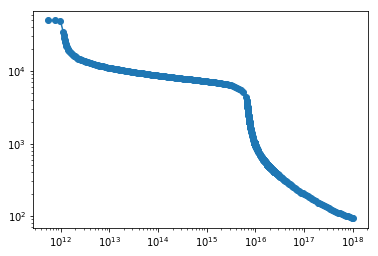

In [20]:
flag = rv_int['successful']
# plt.loglog(rv_int['t'][flag],rv_int['H2_1'][0][flag],'-o')
# plt.loglog(rv_int['t'][flag],rv_int['H_1'][0][flag],'-o')
plt.loglog(rv_int['t'][flag],rv_int['T'][0][flag],'-o')
rv_int['T'][0][flag][-1]

In [21]:
rv_int

{'H2_1': array([[  7.01499061e-22,   8.34613693e-19,   2.01611222e-15,
           1.04853385e-11,   2.29130808e-10,   6.79369559e-10,
           1.01966874e-09,   1.45581730e-09,   1.96693363e-09,
           2.51714581e-09,   3.08719671e-09,   3.67129569e-09,
           4.27161341e-09,   4.89380327e-09,   5.54410114e-09,
           6.22793294e-09,   6.94960210e-09,   7.71240690e-09,
           8.51893335e-09,   9.37133747e-09,   1.02715174e-08,
           1.12212674e-08,   1.22223007e-08,   1.32764684e-08,
           1.43856761e-08,   1.55519188e-08,   1.67772149e-08,
           1.80638373e-08,   1.94144197e-08,   2.08309714e-08,
           2.23165716e-08,   2.38736211e-08,   2.55054560e-08,
           2.72142608e-08,   2.90045724e-08,   3.08781498e-08,
           3.28387568e-08,   3.48908842e-08,   3.70380232e-08,
           3.92823943e-08,   4.16284930e-08,   4.40807508e-08,
           4.66434455e-08,   4.93207740e-08,   5.21169009e-08,
           5.50359917e-08,   5.80822256e-08,   

93.337715461052497

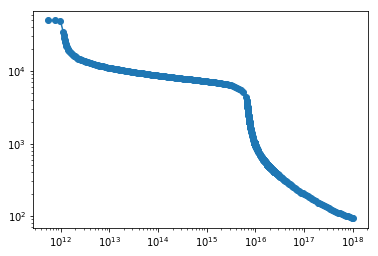

In [22]:
flag = rv_int['successful']
# plt.loglog(rv_int['t'][flag],rv_int['H2_1'][0][flag],'-o')
# plt.loglog(rv_int['t'][flag],rv_int['H_1'][0][flag],'-o')
plt.loglog(rv_int['t'][flag],rv_int['T'][0][flag],'-o')
rv_int['T'][0][flag][-1]

In [23]:
total_t = 0.0
final_density = 1.0e16*1.00794
density_array = numpy.array([ init['density'] ])
pressure_array = numpy.array([])
ttt = []
run_time = []
current_density = density_array[-1]

all_data = {}
for key in init.keys():
    all_data[key] = []
all_data['force_factor'] = []

In [24]:
dir_ff_grackle = "/home/kwoksun2/grackle/src/python/examples/freefall.h5"
import h5py
f = h5py.File(dir_ff_grackle)
fdata = f['data']
grackle_init = convert_from_grackle_to_dengo(fdata)


new_init, primordial = Init_values(np.array([temperature]), np.array([density]) , n_species = 9)
for i in new_init.keys():
    if i not in ['density','ge']:
        print(i, grackle_init[i]) 
        new_init[i] = numpy.array([grackle_init[i]])

new_init['de'] = primordial.calculate_free_electrons(new_init)
new_init['ge'] =  calculate_energy(new_init, primordial)
rv, rv_int = chemistry_run.run_cvdls_9species(new_init, 1e-5,niter=1e0)

Adding reaction: k01 : 1*H_1 + 1*de => 1*H_2 + 2*de
Adding reaction: k02 : 1*H_2 + 1*de => 1*H_1
Adding reaction: k03 : 1*He_1 + 1*de => 1*He_2 + 2*de
Adding reaction: k04 : 1*He_2 + 1*de => 1*He_1
Adding reaction: k05 : 1*He_2 + 1*de => 1*He_3 + 2*de
Adding reaction: k06 : 1*He_3 + 1*de => 1*He_2
Adding reaction: k07 : 1*H_1 + 1*de => 1*H_m0
Adding reaction: k08 : 1*H_m0 + 1*H_1 => 1*H2_1 + 1*de
Adding reaction: k09 : 1*H_1 + 1*H_2 => 1*H2_2
Adding reaction: k10 : 1*H2_2 + 1*H_1 => 1*H2_1 + 1*H_2
Adding reaction: k11 : 1*H2_1 + 1*H_2 => 1*H2_2 + 1*H_1
Adding reaction: k12 : 1*H2_1 + 1*de => 2*H_1 + 1*de
Adding reaction: k13 : 1*H2_1 + 1*H_1 => 3*H_1
Adding reaction: k14 : 1*H_m0 + 1*de => 1*H_1 + 2*de
Adding reaction: k15 : 1*H_m0 + 1*H_1 => 2*H_1 + 1*de
Adding reaction: k16 : 1*H_m0 + 1*H_2 => 2*H_1
Adding reaction: k17 : 1*H_m0 + 1*H_2 => 1*H2_2 + 1*de
Adding reaction: k18 : 1*H2_2 + 1*de => 2*H_1
Adding reaction: k19 : 1*H2_2 + 1*H_m0 => 1*H_1 + 1*H2_1
Adding reaction: k21 : 2*H_1 

In [25]:
flag = rv_int['successful']
de = numpy.zeros((1))
for sp in new_init.keys():
    if sp not in ['de','density','ge','T']:
        s = species_registry[sp]
        print(s.name)
        de += rv_int[s.name][0][flag][-1]  * s.free_electrons

H_2
H_1
He_1
He_2
He_3
H2_2
H2_1
H_m0


In [26]:
while current_density < final_density:

    # keep track of time in here
    
    new_init = generate_init_from_results(rv_int,primordial, new_init)
    init, pressure_array, density_array, dt, force_factor = update_initial_condition(new_init, primordial, pressure_array
                                                             , density_array, safety_factor=0.01)
    tic = time.time()
    rv, rv_int = chemistry_run.run_cvdls_9species(init, dt,niter=1e5)
    toc = time.time()
    total_t += dt
    ttt.append(float(total_t))
    run_time.append(toc-tic)
    
    flag = rv_int['successful']
    for key in init.keys():
        if key not in ['density']:
            data = rv_int[key][0][flag][-1]
            all_data[key].append(data)
    all_data['force_factor'].append( float(force_factor))
    current_density = density_array[-1]
    
    
    t_ends = rv_int['t'][flag][-1]
    if t_ends < dt:
        print('##########cannot finish the run....####################3')
        break

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917811053
initial  temperature: 8.180E+01
Successful iteration[    0]: (1.451e+08) 1.451e+08 / 1.451e+13
End in 97 iterations: 1.45084e+13 / 1.45084e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917810636
initial  temperature: 8.234E+01
Successful iteration[    0]: (1.444e+08) 1.444e+08 / 1.444e+13
End in 97 iterations: 1.44358e+13 / 1.44358e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917810213
initial  temperature: 8.289E+01
Successful iteration[    0]: (1.436e+08) 1.436e+08 / 1.436e+13
End in 97 iterations: 1.43636e+13 / 1.43636e+13 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.66491779961
initial  temperature: 9.596E+01
Successful iteration[    0]: (1.286e+08) 1.286e+08 / 1.286e+13
End in 97 iterations: 1.28639e+13 / 1.28639e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917799063
initial  temperature: 9.660E+01
Successful iteration[    0]: (1.280e+08) 1.280e+08 / 1.280e+13
End in 97 iterations: 1.27996e+13 / 1.27996e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491779851
initial  temperature: 9.724E+01
Successful iteration[    0]: (1.274e+08) 1.274e+08 / 1.274e+13
End in 97 iterations: 1.27356e+13 / 1.27356e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Specie

Successful iteration[    0]: (1.141e+08) 1.141e+08 / 1.141e+13
End in 97 iterations: 1.14058e+13 / 1.14058e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917783914
initial  temperature: 1.133E+02
Successful iteration[    0]: (1.135e+08) 1.135e+08 / 1.135e+13
End in 97 iterations: 1.13488e+13 / 1.13488e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491778319
initial  temperature: 1.140E+02
Successful iteration[    0]: (1.129e+08) 1.129e+08 / 1.129e+13
End in 97 iterations: 1.12920e+13 / 1.12920e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917782458
initial  temperature: 1.1

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917764099
initial  temperature: 1.328E+02
Successful iteration[    0]: (1.006e+08) 1.006e+08 / 1.006e+13
End in 97 iterations: 1.00624e+13 / 1.00624e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917763152
initial  temperature: 1.337E+02
Successful iteration[    0]: (1.001e+08) 1.001e+08 / 1.001e+13
End in 97 iterations: 1.00121e+13 / 1.00121e+13 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917762195
initial  temperature: 1.346E+02
Successful iteration[    0]: (9.962e+07) 9.962e+07 / 9.962e+12
End in 97 iterations: 9.96207e+12 / 9.96207e+12 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664917738203
initial  temperature: 1.556E+02
Successful iteration[    0]: (8.922e+07) 8.922e+07 / 8.922e+12
End in 97 iterations: 8.92190e+12 / 8.92190e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917736967
initial  temperature: 1.566E+02
Successful iteration[    0]: (8.877e+07) 8.877e+07 / 8.877e+12
End in 97 iterations: 8.87729e+12 / 8.87729e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917735717
initial  temperature: 1.576E+02
Successful iteration[    0]: (8.833e+07) 8.833e+07 / 8.833e+12
End in 97 iterations: 8.83290e+12 / 8.83290e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (7.911e+07) 7.911e+07 / 7.911e+12
End in 97 iterations: 7.91063e+12 / 7.91063e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917702798
initial  temperature: 1.832E+02
Successful iteration[    0]: (7.871e+07) 7.871e+07 / 7.871e+12
End in 97 iterations: 7.87108e+12 / 7.87108e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917701169
initial  temperature: 1.844E+02
Successful iteration[    0]: (7.832e+07) 7.832e+07 / 7.832e+12
End in 97 iterations: 7.83172e+12 / 7.83172e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917699521
initial  temperature: 1.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917658303
initial  temperature: 2.139E+02
Successful iteration[    0]: (6.979e+07) 6.979e+07 / 6.979e+12
End in 97 iterations: 6.97892e+12 / 6.97892e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917656184
initial  temperature: 2.153E+02
Successful iteration[    0]: (6.944e+07) 6.944e+07 / 6.944e+12
End in 97 iterations: 6.94402e+12 / 6.94402e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917654041
initial  temperature: 2.167E+02
Successful iteration[    0]: (6.909e+07) 6.909e+07 / 6.909e+12
End in 97 iterations: 6.90930e+12 / 6.90930e+12 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664917600536
initial  temperature: 2.490E+02
Successful iteration[    0]: (6.188e+07) 6.188e+07 / 6.188e+12
End in 97 iterations: 6.18788e+12 / 6.18788e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491759779
initial  temperature: 2.505E+02
Successful iteration[    0]: (6.157e+07) 6.157e+07 / 6.157e+12
End in 97 iterations: 6.15694e+12 / 6.15694e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917595014
initial  temperature: 2.521E+02
Successful iteration[    0]: (6.126e+07) 6.126e+07 / 6.126e+12
End in 97 iterations: 6.12616e+12 / 6.12616e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Speci

Successful iteration[    0]: (5.487e+07) 5.487e+07 / 5.487e+12
End in 97 iterations: 5.48651e+12 / 5.48651e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491752233
initial  temperature: 2.901E+02
Successful iteration[    0]: (5.459e+07) 5.459e+07 / 5.459e+12
End in 97 iterations: 5.45908e+12 / 5.45908e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917518753
initial  temperature: 2.919E+02
Successful iteration[    0]: (5.432e+07) 5.432e+07 / 5.432e+12
End in 97 iterations: 5.43178e+12 / 5.43178e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917515139
initial  temperature: 2.9

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917425453
initial  temperature: 3.334E+02
Successful iteration[    0]: (4.840e+07) 4.840e+07 / 4.840e+12
End in 97 iterations: 4.84031e+12 / 4.84031e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491742088
initial  temperature: 3.353E+02
Successful iteration[    0]: (4.816e+07) 4.816e+07 / 4.816e+12
End in 97 iterations: 4.81611e+12 / 4.81611e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917416262
initial  temperature: 3.372E+02
Successful iteration[    0]: (4.792e+07) 4.792e+07 / 4.792e+12
End in 97 iterations: 4.79203e+12 / 4.79203e+12 (0.0000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664917302244
initial  temperature: 3.789E+02
Successful iteration[    0]: (4.292e+07) 4.292e+07 / 4.292e+12
End in 97 iterations: 4.29168e+12 / 4.29168e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917296463
initial  temperature: 3.808E+02
Successful iteration[    0]: (4.270e+07) 4.270e+07 / 4.270e+12
End in 97 iterations: 4.27022e+12 / 4.27022e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917290627
initial  temperature: 3.827E+02
Successful iteration[    0]: (4.249e+07) 4.249e+07 / 4.249e+12
End in 97 iterations: 4.24887e+12 / 4.24887e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

initial  temperature: 4.236E+02
Successful iteration[    0]: (3.805e+07) 3.805e+07 / 3.805e+12
End in 97 iterations: 3.80523e+12 / 3.80523e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917140422
initial  temperature: 4.254E+02
Successful iteration[    0]: (3.786e+07) 3.786e+07 / 3.786e+12
End in 97 iterations: 3.78620e+12 / 3.78620e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664917133164
initial  temperature: 4.271E+02
Successful iteration[    0]: (3.767e+07) 3.767e+07 / 3.767e+12
End in 97 iterations: 3.76727e+12 / 3.76727e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491

End in 97 iterations: 3.37392e+12 / 3.37392e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916948266
initial  temperature: 4.646E+02
Successful iteration[    0]: (3.357e+07) 3.357e+07 / 3.357e+12
End in 97 iterations: 3.35705e+12 / 3.35705e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916939425
initial  temperature: 4.660E+02
Successful iteration[    0]: (3.340e+07) 3.340e+07 / 3.340e+12
End in 97 iterations: 3.34027e+12 / 3.34027e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916930515
initial  temperature: 4.674E+02
Successful iteration[    0]: (3.324e+07) 3.324e+07 / 3.

Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916716987
initial  temperature: 4.938E+02
Successful iteration[    0]: (2.977e+07) 2.977e+07 / 2.977e+12
End in 97 iterations: 2.97654e+12 / 2.97654e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491670648
initial  temperature: 4.947E+02
Successful iteration[    0]: (2.962e+07) 2.962e+07 / 2.962e+12
End in 97 iterations: 2.96166e+12 / 2.96166e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916695902
initial  temperature: 4.956E+02
Successful iteration[    0]: (2.947e+07) 2.947e+07 / 2.947e+12
End in 97 iterations: 2.94685e+12 / 2.94685e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species

initial  temperature: 5.102E+02
Successful iteration[    0]: (2.639e+07) 2.639e+07 / 2.639e+12
End in 97 iterations: 2.63916e+12 / 2.63916e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916433354
initial  temperature: 5.106E+02
Successful iteration[    0]: (2.626e+07) 2.626e+07 / 2.626e+12
End in 97 iterations: 2.62596e+12 / 2.62596e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916421106
initial  temperature: 5.110E+02
Successful iteration[    0]: (2.613e+07) 2.613e+07 / 2.613e+12
End in 97 iterations: 2.61284e+12 / 2.61284e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491

End in 97 iterations: 2.34002e+12 / 2.34002e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916120544
initial  temperature: 5.143E+02
Successful iteration[    0]: (2.328e+07) 2.328e+07 / 2.328e+12
End in 97 iterations: 2.32832e+12 / 2.32832e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916106663
initial  temperature: 5.142E+02
Successful iteration[    0]: (2.317e+07) 2.317e+07 / 2.317e+12
End in 97 iterations: 2.31668e+12 / 2.31668e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664916092715
initial  temperature: 5.141E+02
Successful iteration[    0]: (2.305e+07) 2.305e+07 / 2.

Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664915768947
initial  temperature: 5.086E+02
Successful iteration[    0]: (2.064e+07) 2.064e+07 / 2.064e+12
End in 97 iterations: 2.06441e+12 / 2.06441e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664915753464
initial  temperature: 5.082E+02
Successful iteration[    0]: (2.054e+07) 2.054e+07 / 2.054e+12
End in 97 iterations: 2.05409e+12 / 2.05409e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664915737915
initial  temperature: 5.078E+02
Successful iteration[    0]: (2.044e+07) 2.044e+07 / 2.044e+12
End in 97 iterations: 2.04382e+12 / 2.04382e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Specie

initial  temperature: 4.970E+02
Successful iteration[    0]: (1.830e+07) 1.830e+07 / 1.830e+12
End in 97 iterations: 1.83042e+12 / 1.83042e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664915361901
initial  temperature: 4.964E+02
Successful iteration[    0]: (1.821e+07) 1.821e+07 / 1.821e+12
End in 97 iterations: 1.82127e+12 / 1.82127e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491534475
initial  temperature: 4.958E+02
Successful iteration[    0]: (1.812e+07) 1.812e+07 / 1.812e+12
End in 97 iterations: 1.81216e+12 / 1.81216e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664915

End in 97 iterations: 1.62295e+12 / 1.62295e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664914931552
initial  temperature: 4.811E+02
Successful iteration[    0]: (1.615e+07) 1.615e+07 / 1.615e+12
End in 97 iterations: 1.61483e+12 / 1.61483e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664914912764
initial  temperature: 4.804E+02
Successful iteration[    0]: (1.607e+07) 1.607e+07 / 1.607e+12
End in 97 iterations: 1.60676e+12 / 1.60676e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664914893906
initial  temperature: 4.798E+02
Successful iteration[    0]: (1.599e+07) 1.599e+07 / 1.

Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491446124
initial  temperature: 4.641E+02
Successful iteration[    0]: (1.432e+07) 1.432e+07 / 1.432e+12
End in 97 iterations: 1.43180e+12 / 1.43180e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664914440752
initial  temperature: 4.634E+02
Successful iteration[    0]: (1.425e+07) 1.425e+07 / 1.425e+12
End in 97 iterations: 1.42464e+12 / 1.42464e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664914420192
initial  temperature: 4.626E+02
Successful iteration[    0]: (1.418e+07) 1.418e+07 / 1.418e+12
End in 97 iterations: 1.41752e+12 / 1.41752e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species

initial  temperature: 4.462E+02
Successful iteration[    0]: (1.270e+07) 1.270e+07 / 1.270e+12
End in 97 iterations: 1.26951e+12 / 1.26951e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664913926947
initial  temperature: 4.455E+02
Successful iteration[    0]: (1.263e+07) 1.263e+07 / 1.263e+12
End in 97 iterations: 1.26316e+12 / 1.26316e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664913904601
initial  temperature: 4.447E+02
Successful iteration[    0]: (1.257e+07) 1.257e+07 / 1.257e+12
End in 97 iterations: 1.25685e+12 / 1.25685e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491

End in 97 iterations: 1.12561e+12 / 1.12561e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664913369188
initial  temperature: 4.273E+02
Successful iteration[    0]: (1.120e+07) 1.120e+07 / 1.120e+12
End in 97 iterations: 1.11999e+12 / 1.11999e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664913344959
initial  temperature: 4.265E+02
Successful iteration[    0]: (1.114e+07) 1.114e+07 / 1.114e+12
End in 97 iterations: 1.11439e+12 / 1.11439e+12 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491332065
initial  temperature: 4.258E+02
Successful iteration[    0]: (1.109e+07) 1.109e+07 / 1.1

Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664912791122
initial  temperature: 4.099E+02
Successful iteration[    0]: (9.980e+06) 9.980e+06 / 9.980e+11
End in 97 iterations: 9.98030e+11 / 9.98030e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491276499
initial  temperature: 4.092E+02
Successful iteration[    0]: (9.930e+06) 9.930e+06 / 9.930e+11
End in 97 iterations: 9.93040e+11 / 9.93040e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664912738773
initial  temperature: 4.084E+02
Successful iteration[    0]: (9.881e+06) 9.881e+06 / 9.881e+11
End in 97 iterations: 9.88074e+11 / 9.88074e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species

Successful iteration[    0]: (8.849e+06) 8.849e+06 / 8.849e+11
End in 97 iterations: 8.84907e+11 / 8.84907e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664912111834
initial  temperature: 3.913E+02
Successful iteration[    0]: (8.805e+06) 8.805e+06 / 8.805e+11
End in 97 iterations: 8.80482e+11 / 8.80482e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664912083514
initial  temperature: 3.905E+02
Successful iteration[    0]: (8.761e+06) 8.761e+06 / 8.761e+11
End in 100 iterations: 8.76080e+11 / 8.76080e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664912055105
initial  temperature: 3

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664911406859
initial  temperature: 3.738E+02
Successful iteration[    0]: (7.807e+06) 7.807e+06 / 7.807e+11
End in 97 iterations: 7.80683e+11 / 7.80683e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664911376318
initial  temperature: 3.730E+02
Successful iteration[    0]: (7.768e+06) 7.768e+06 / 7.768e+11
End in 97 iterations: 7.76779e+11 / 7.76779e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664911345681
initial  temperature: 3.723E+02
Successful iteration[    0]: (7.729e+06) 7.729e+06 / 7.729e+11
End in 97 iterations: 7.72895e+11 / 7.72895e+11 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664910647103
initial  temperature: 3.567E+02
Successful iteration[    0]: (6.922e+06) 6.922e+06 / 6.922e+11
End in 97 iterations: 6.92195e+11 / 6.92195e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664910614212
initial  temperature: 3.560E+02
Successful iteration[    0]: (6.887e+06) 6.887e+06 / 6.887e+11
End in 97 iterations: 6.88734e+11 / 6.88734e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66491058122
initial  temperature: 3.553E+02
Successful iteration[    0]: (6.853e+06) 6.853e+06 / 6.853e+11
End in 97 iterations: 6.85290e+11 / 6.85290e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Speci

Successful iteration[    0]: (6.137e+06) 6.137e+06 / 6.137e+11
End in 97 iterations: 6.13737e+11 / 6.13737e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664909794036
initial  temperature: 3.396E+02
Successful iteration[    0]: (6.107e+06) 6.107e+06 / 6.107e+11
End in 97 iterations: 6.10668e+11 / 6.10668e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664909758553
initial  temperature: 3.390E+02
Successful iteration[    0]: (6.076e+06) 6.076e+06 / 6.076e+11
End in 97 iterations: 6.07615e+11 / 6.07615e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664909722963
initial  temperature: 3.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664908912393
initial  temperature: 3.239E+02
Successful iteration[    0]: (5.415e+06) 5.415e+06 / 5.415e+11
End in 97 iterations: 5.41451e+11 / 5.41451e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66490887427
initial  temperature: 3.233E+02
Successful iteration[    0]: (5.387e+06) 5.387e+06 / 5.387e+11
End in 97 iterations: 5.38744e+11 / 5.38744e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664908836035
initial  temperature: 3.227E+02
Successful iteration[    0]: (5.361e+06) 5.361e+06 / 5.361e+11
End in 97 iterations: 5.36050e+11 / 5.36050e+11 (0.0000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664907965589
initial  temperature: 3.090E+02
Successful iteration[    0]: (4.801e+06) 4.801e+06 / 4.801e+11
End in 97 iterations: 4.80080e+11 / 4.80080e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664907924666
initial  temperature: 3.084E+02
Successful iteration[    0]: (4.777e+06) 4.777e+06 / 4.777e+11
End in 97 iterations: 4.77679e+11 / 4.77679e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664907883623
initial  temperature: 3.078E+02
Successful iteration[    0]: (4.753e+06) 4.753e+06 / 4.753e+11
End in 97 iterations: 4.75291e+11 / 4.75291e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (4.257e+06) 4.257e+06 / 4.257e+11
End in 97 iterations: 4.25664e+11 / 4.25664e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664906905658
initial  temperature: 2.943E+02
Successful iteration[    0]: (4.235e+06) 4.235e+06 / 4.235e+11
End in 97 iterations: 4.23536e+11 / 4.23536e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664906861628
initial  temperature: 2.938E+02
Successful iteration[    0]: (4.214e+06) 4.214e+06 / 4.214e+11
End in 97 iterations: 4.21418e+11 / 4.21418e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664906817469
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66490581269
initial  temperature: 2.812E+02
Successful iteration[    0]: (3.755e+06) 3.755e+06 / 3.755e+11
End in 97 iterations: 3.75530e+11 / 3.75530e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664905765471
initial  temperature: 2.807E+02
Successful iteration[    0]: (3.737e+06) 3.737e+06 / 3.737e+11
End in 97 iterations: 3.73652e+11 / 3.73652e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664905718115
initial  temperature: 2.801E+02
Successful iteration[    0]: (3.718e+06) 3.718e+06 / 3.718e+11
End in 97 iterations: 3.71784e+11 / 3.71784e+11 (0.0000

force_factor: 0.0
gammma - 1: 0.664904640644
initial  temperature: 2.690E+02
Successful iteration[    0]: (3.330e+06) 3.330e+06 / 3.330e+11
End in 97 iterations: 3.32965e+11 / 3.32965e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664904590009
initial  temperature: 2.685E+02
Successful iteration[    0]: (3.313e+06) 3.313e+06 / 3.313e+11
End in 97 iterations: 3.31300e+11 / 3.31300e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664904539227
initial  temperature: 2.681E+02
Successful iteration[    0]: (3.296e+06) 3.296e+06 / 3.296e+11
End in 97 iterations: 3.29643e+11 / 3.29643e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Speci

Successful iteration[    0]: (2.952e+06) 2.952e+06 / 2.952e+11
End in 97 iterations: 2.95224e+11 / 2.95224e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664903329407
initial  temperature: 2.574E+02
Successful iteration[    0]: (2.937e+06) 2.937e+06 / 2.937e+11
End in 97 iterations: 2.93748e+11 / 2.93748e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664903274939
initial  temperature: 2.570E+02
Successful iteration[    0]: (2.923e+06) 2.923e+06 / 2.923e+11
End in 97 iterations: 2.92279e+11 / 2.92279e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664903220312
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664901977004
initial  temperature: 2.474E+02
Successful iteration[    0]: (2.605e+06) 2.605e+06 / 2.605e+11
End in 97 iterations: 2.60453e+11 / 2.60453e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664901918552
initial  temperature: 2.470E+02
Successful iteration[    0]: (2.592e+06) 2.592e+06 / 2.592e+11
End in 97 iterations: 2.59151e+11 / 2.59151e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664901859928
initial  temperature: 2.466E+02
Successful iteration[    0]: (2.579e+06) 2.579e+06 / 2.579e+11
End in 97 iterations: 2.57855e+11 / 2.57855e+11 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664900525158
initial  temperature: 2.385E+02
Successful iteration[    0]: (2.309e+06) 2.309e+06 / 2.309e+11
End in 97 iterations: 2.30931e+11 / 2.30931e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664900462381
initial  temperature: 2.381E+02
Successful iteration[    0]: (2.298e+06) 2.298e+06 / 2.298e+11
End in 97 iterations: 2.29777e+11 / 2.29777e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664900399416
initial  temperature: 2.378E+02
Successful iteration[    0]: (2.286e+06) 2.286e+06 / 2.286e+11
End in 97 iterations: 2.28628e+11 / 2.28628e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (2.048e+06) 2.048e+06 / 2.048e+11
End in 97 iterations: 2.04756e+11 / 2.04756e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664898897583
initial  temperature: 2.303E+02
Successful iteration[    0]: (2.037e+06) 2.037e+06 / 2.037e+11
End in 97 iterations: 2.03732e+11 / 2.03732e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664898829881
initial  temperature: 2.300E+02
Successful iteration[    0]: (2.027e+06) 2.027e+06 / 2.027e+11
End in 97 iterations: 2.02714e+11 / 2.02714e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664898761971
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664897213966
initial  temperature: 2.237E+02
Successful iteration[    0]: (1.806e+06) 1.806e+06 / 1.806e+11
End in 97 iterations: 1.80640e+11 / 1.80640e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66489714107
initial  temperature: 2.234E+02
Successful iteration[    0]: (1.797e+06) 1.797e+06 / 1.797e+11
End in 97 iterations: 1.79737e+11 / 1.79737e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664897067946
initial  temperature: 2.232E+02
Successful iteration[    0]: (1.788e+06) 1.788e+06 / 1.788e+11
End in 97 iterations: 1.78838e+11 / 1.78838e+11 (0.0000

force_factor: 0.0
gammma - 1: 0.664895399796
initial  temperature: 2.182E+02
Successful iteration[    0]: (1.602e+06) 1.602e+06 / 1.602e+11
End in 97 iterations: 1.60165e+11 / 1.60165e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66489532118
initial  temperature: 2.180E+02
Successful iteration[    0]: (1.594e+06) 1.594e+06 / 1.594e+11
End in 97 iterations: 1.59364e+11 / 1.59364e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664895242313
initial  temperature: 2.178E+02
Successful iteration[    0]: (1.586e+06) 1.586e+06 / 1.586e+11
End in 97 iterations: 1.58567e+11 / 1.58567e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Specie

Successful iteration[    0]: (1.420e+06) 1.420e+06 / 1.420e+11
End in 97 iterations: 1.42011e+11 / 1.42011e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664893356681
initial  temperature: 2.137E+02
Successful iteration[    0]: (1.413e+06) 1.413e+06 / 1.413e+11
End in 97 iterations: 1.41301e+11 / 1.41301e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664893271468
initial  temperature: 2.135E+02
Successful iteration[    0]: (1.406e+06) 1.406e+06 / 1.406e+11
End in 97 iterations: 1.40594e+11 / 1.40594e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664893185977
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66489123216
initial  temperature: 2.105E+02
Successful iteration[    0]: (1.253e+06) 1.253e+06 / 1.253e+11
End in 97 iterations: 1.25285e+11 / 1.25285e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664891139916
initial  temperature: 2.104E+02
Successful iteration[    0]: (1.247e+06) 1.247e+06 / 1.247e+11
End in 97 iterations: 1.24659e+11 / 1.24659e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664891047363
initial  temperature: 2.103E+02
Successful iteration[    0]: (1.240e+06) 1.240e+06 / 1.240e+11
End in 97 iterations: 1.24035e+11 / 1.24035e+11 (0.0000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664888930218
initial  temperature: 2.085E+02
Successful iteration[    0]: (1.111e+06) 1.111e+06 / 1.111e+11
End in 97 iterations: 1.11084e+11 / 1.11084e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664888830174
initial  temperature: 2.084E+02
Successful iteration[    0]: (1.105e+06) 1.105e+06 / 1.105e+11
End in 97 iterations: 1.10529e+11 / 1.10529e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664888729786
initial  temperature: 2.084E+02
Successful iteration[    0]: (1.100e+06) 1.100e+06 / 1.100e+11
End in 97 iterations: 1.09976e+11 / 1.09976e+11 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (9.849e+05) 9.849e+05 / 9.849e+10
End in 97 iterations: 9.84933e+10 / 9.84933e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664886322705
initial  temperature: 2.075E+02
Successful iteration[    0]: (9.800e+05) 9.800e+05 / 9.800e+10
End in 97 iterations: 9.80009e+10 / 9.80009e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664886213625
initial  temperature: 2.075E+02
Successful iteration[    0]: (9.751e+05) 9.751e+05 / 9.751e+10
End in 97 iterations: 9.75109e+10 / 9.75109e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664886104162
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664883595907
initial  temperature: 2.077E+02
Successful iteration[    0]: (8.689e+05) 8.689e+05 / 8.689e+10
End in 97 iterations: 8.68928e+10 / 8.68928e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664883477189
initial  temperature: 2.077E+02
Successful iteration[    0]: (8.646e+05) 8.646e+05 / 8.646e+10
End in 97 iterations: 8.64583e+10 / 8.64583e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664883358047
initial  temperature: 2.077E+02
Successful iteration[    0]: (8.603e+05) 8.603e+05 / 8.603e+10
End in 97 iterations: 8.60261e+10 / 8.60261e+10 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664880626128
initial  temperature: 2.088E+02
Successful iteration[    0]: (7.704e+05) 7.704e+05 / 7.704e+10
End in 97 iterations: 7.70438e+10 / 7.70438e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664880496743
initial  temperature: 2.089E+02
Successful iteration[    0]: (7.666e+05) 7.666e+05 / 7.666e+10
End in 97 iterations: 7.66586e+10 / 7.66586e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66488036689
initial  temperature: 2.089E+02
Successful iteration[    0]: (7.628e+05) 7.628e+05 / 7.628e+10
End in 97 iterations: 7.62753e+10 / 7.62753e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Speci

Successful iteration[    0]: (6.831e+05) 6.831e+05 / 6.831e+10
End in 97 iterations: 6.83112e+10 / 6.83112e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66487724656
initial  temperature: 2.110E+02
Successful iteration[    0]: (6.797e+05) 6.797e+05 / 6.797e+10
End in 97 iterations: 6.79696e+10 / 6.79696e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664877104879
initial  temperature: 2.111E+02
Successful iteration[    0]: (6.763e+05) 6.763e+05 / 6.763e+10
End in 97 iterations: 6.76298e+10 / 6.76298e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66487696268
initial  temperature: 2.11

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664873698911
initial  temperature: 2.140E+02
Successful iteration[    0]: (6.027e+05) 6.027e+05 / 6.027e+10
End in 97 iterations: 6.02655e+10 / 6.02655e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664873544207
initial  temperature: 2.141E+02
Successful iteration[    0]: (5.996e+05) 5.996e+05 / 5.996e+10
End in 97 iterations: 5.99642e+10 / 5.99642e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664873388932
initial  temperature: 2.143E+02
Successful iteration[    0]: (5.966e+05) 5.966e+05 / 5.966e+10
End in 97 iterations: 5.96643e+10 / 5.96643e+10 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664869824143
initial  temperature: 2.179E+02
Successful iteration[    0]: (5.343e+05) 5.343e+05 / 5.343e+10
End in 97 iterations: 5.34346e+10 / 5.34346e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664869655135
initial  temperature: 2.181E+02
Successful iteration[    0]: (5.317e+05) 5.317e+05 / 5.317e+10
End in 97 iterations: 5.31674e+10 / 5.31674e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664869485503
initial  temperature: 2.182E+02
Successful iteration[    0]: (5.290e+05) 5.290e+05 / 5.290e+10
End in 97 iterations: 5.29016e+10 / 5.29016e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (4.738e+05) 4.738e+05 / 4.738e+10
End in 97 iterations: 4.73780e+10 / 4.73780e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664865406031
initial  temperature: 2.228E+02
Successful iteration[    0]: (4.714e+05) 4.714e+05 / 4.714e+10
End in 97 iterations: 4.71411e+10 / 4.71411e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664865220683
initial  temperature: 2.230E+02
Successful iteration[    0]: (4.691e+05) 4.691e+05 / 4.691e+10
End in 97 iterations: 4.69054e+10 / 4.69054e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66486503465
initial  temperature: 2.2

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664860763387
initial  temperature: 2.283E+02
Successful iteration[    0]: (4.180e+05) 4.180e+05 / 4.180e+10
End in 97 iterations: 4.17978e+10 / 4.17978e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664860560888
initial  temperature: 2.286E+02
Successful iteration[    0]: (4.159e+05) 4.159e+05 / 4.159e+10
End in 97 iterations: 4.15888e+10 / 4.15888e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664860357643
initial  temperature: 2.288E+02
Successful iteration[    0]: (4.138e+05) 4.138e+05 / 4.138e+10
End in 97 iterations: 4.13809e+10 / 4.13809e+10 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664855691899
initial  temperature: 2.346E+02
Successful iteration[    0]: (3.706e+05) 3.706e+05 / 3.706e+10
End in 97 iterations: 3.70602e+10 / 3.70602e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664855470739
initial  temperature: 2.348E+02
Successful iteration[    0]: (3.687e+05) 3.687e+05 / 3.687e+10
End in 97 iterations: 3.68749e+10 / 3.68749e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664855248768
initial  temperature: 2.351E+02
Successful iteration[    0]: (3.669e+05) 3.669e+05 / 3.669e+10
End in 97 iterations: 3.66905e+10 / 3.66905e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (3.286e+05) 3.286e+05 / 3.286e+10
End in 97 iterations: 3.28595e+10 / 3.28595e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664849913109
initial  temperature: 2.418E+02
Successful iteration[    0]: (3.270e+05) 3.270e+05 / 3.270e+10
End in 97 iterations: 3.26952e+10 / 3.26952e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664849670831
initial  temperature: 2.421E+02
Successful iteration[    0]: (3.253e+05) 3.253e+05 / 3.253e+10
End in 97 iterations: 3.25318e+10 / 3.25318e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66484942767
initial  temperature: 2.4

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664843849272
initial  temperature: 2.495E+02
Successful iteration[    0]: (2.899e+05) 2.899e+05 / 2.899e+10
End in 97 iterations: 2.89894e+10 / 2.89894e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664843585037
initial  temperature: 2.498E+02
Successful iteration[    0]: (2.884e+05) 2.884e+05 / 2.884e+10
End in 97 iterations: 2.88444e+10 / 2.88444e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664843319851
initial  temperature: 2.501E+02
Successful iteration[    0]: (2.870e+05) 2.870e+05 / 2.870e+10
End in 97 iterations: 2.87002e+10 / 2.87002e+10 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664837239036
initial  temperature: 2.577E+02
Successful iteration[    0]: (2.570e+05) 2.570e+05 / 2.570e+10
End in 97 iterations: 2.57035e+10 / 2.57035e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664836951143
initial  temperature: 2.581E+02
Successful iteration[    0]: (2.557e+05) 2.557e+05 / 2.557e+10
End in 97 iterations: 2.55750e+10 / 2.55750e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664836662227
initial  temperature: 2.584E+02
Successful iteration[    0]: (2.545e+05) 2.545e+05 / 2.545e+10
End in 97 iterations: 2.54471e+10 / 2.54471e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (2.279e+05) 2.279e+05 / 2.279e+10
End in 97 iterations: 2.27901e+10 / 2.27901e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664829727668
initial  temperature: 2.670E+02
Successful iteration[    0]: (2.268e+05) 2.268e+05 / 2.268e+10
End in 97 iterations: 2.26762e+10 / 2.26762e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66482941327
initial  temperature: 2.674E+02
Successful iteration[    0]: (2.256e+05) 2.256e+05 / 2.256e+10
End in 97 iterations: 2.25628e+10 / 2.25628e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664829097773
initial  temperature: 2.6

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664821872149
initial  temperature: 2.764E+02
Successful iteration[    0]: (2.011e+05) 2.011e+05 / 2.011e+10
End in 97 iterations: 2.01059e+10 / 2.01059e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664821530484
initial  temperature: 2.768E+02
Successful iteration[    0]: (2.001e+05) 2.001e+05 / 2.001e+10
End in 97 iterations: 2.00054e+10 / 2.00054e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664821187644
initial  temperature: 2.772E+02
Successful iteration[    0]: (1.991e+05) 1.991e+05 / 1.991e+10
End in 97 iterations: 1.99053e+10 / 1.99053e+10 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664813341438
initial  temperature: 2.863E+02
Successful iteration[    0]: (1.783e+05) 1.783e+05 / 1.783e+10
End in 97 iterations: 1.78270e+10 / 1.78270e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664812970698
initial  temperature: 2.868E+02
Successful iteration[    0]: (1.774e+05) 1.774e+05 / 1.774e+10
End in 97 iterations: 1.77378e+10 / 1.77378e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664812598707
initial  temperature: 2.872E+02
Successful iteration[    0]: (1.765e+05) 1.765e+05 / 1.765e+10
End in 97 iterations: 1.76491e+10 / 1.76491e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (1.581e+05) 1.581e+05 / 1.581e+10
End in 97 iterations: 1.58063e+10 / 1.58063e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664803690404
initial  temperature: 2.972E+02
Successful iteration[    0]: (1.573e+05) 1.573e+05 / 1.573e+10
End in 97 iterations: 1.57273e+10 / 1.57273e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664803287446
initial  temperature: 2.976E+02
Successful iteration[    0]: (1.565e+05) 1.565e+05 / 1.565e+10
End in 97 iterations: 1.56487e+10 / 1.56487e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664802883156
initial  temperature: 2.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664793646019
initial  temperature: 3.080E+02
Successful iteration[    0]: (1.394e+05) 1.394e+05 / 1.394e+10
End in 97 iterations: 1.39447e+10 / 1.39447e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664793210279
initial  temperature: 3.084E+02
Successful iteration[    0]: (1.387e+05) 1.387e+05 / 1.387e+10
End in 97 iterations: 1.38749e+10 / 1.38749e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664792773134
initial  temperature: 3.089E+02
Successful iteration[    0]: (1.381e+05) 1.381e+05 / 1.381e+10
End in 97 iterations: 1.38056e+10 / 1.38056e+10 (0.000

Species: H_2
force_factor: 0.0
gammma - 1: 0.664782794249
initial  temperature: 3.192E+02
Successful iteration[    0]: (1.236e+05) 1.236e+05 / 1.236e+10
End in 97 iterations: 1.23641e+10 / 1.23641e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664782323935
initial  temperature: 3.196E+02
Successful iteration[    0]: (1.230e+05) 1.230e+05 / 1.230e+10
End in 97 iterations: 1.23023e+10 / 1.23023e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664781852143
initial  temperature: 3.201E+02
Successful iteration[    0]: (1.224e+05) 1.224e+05 / 1.224e+10
End in 97 iterations: 1.22408e+10 / 1.22408e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Spec

Successful iteration[    0]: (1.096e+05) 1.096e+05 / 1.096e+10
End in 97 iterations: 1.09627e+10 / 1.09627e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664770585718
initial  temperature: 3.311E+02
Successful iteration[    0]: (1.091e+05) 1.091e+05 / 1.091e+10
End in 97 iterations: 1.09079e+10 / 1.09079e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664770077517
initial  temperature: 3.316E+02
Successful iteration[    0]: (1.085e+05) 1.085e+05 / 1.085e+10
End in 97 iterations: 1.08533e+10 / 1.08533e+10 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664769567763
initial  temperature: 3.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664757953711
initial  temperature: 3.429E+02
Successful iteration[    0]: (9.671e+04) 9.671e+04 / 9.671e+09
End in 97 iterations: 9.67149e+09 / 9.67149e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664757407373
initial  temperature: 3.434E+02
Successful iteration[    0]: (9.623e+04) 9.623e+04 / 9.623e+09
End in 97 iterations: 9.62313e+09 / 9.62313e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664756859409
initial  temperature: 3.439E+02
Successful iteration[    0]: (9.575e+04) 9.575e+04 / 9.575e+09
End in 97 iterations: 9.57501e+09 / 9.57501e+09 (0.000

Successful iteration[    0]: (8.662e+04) 8.662e+04 / 8.662e+09
Successful iteration[  100]: (5.036e+05) 2.603e+09 / 8.662e+09
Successful iteration[  200]: (2.469e+06) 5.096e+09 / 8.662e+09
End in 253 iterations: 8.66166e+09 / 8.66166e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664744971381
initial  temperature: 3.544E+02
Successful iteration[    0]: (8.618e+04) 8.618e+04 / 8.618e+09
End in 97 iterations: 8.61835e+09 / 8.61835e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66474438691
initial  temperature: 3.549E+02
Successful iteration[    0]: (8.575e+04) 8.575e+04 / 8.575e+09
Successful iteration[  100]: (2.155e+06) 3.696e+09 / 8.575e+09
End in 157 iterations: 8.57526e+09 / 8.57526e+09 (0.00000e+00)
Species: H2_1

initial  temperature: 3.645E+02
Successful iteration[    0]: (7.796e+04) 7.796e+04 / 7.796e+09
End in 97 iterations: 7.79625e+09 / 7.79625e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664732338295
initial  temperature: 3.650E+02
Successful iteration[    0]: (7.757e+04) 7.757e+04 / 7.757e+09
End in 97 iterations: 7.75727e+09 / 7.75727e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664731717684
initial  temperature: 3.655E+02
Successful iteration[    0]: (7.718e+04) 7.718e+04 / 7.718e+09
End in 97 iterations: 7.71848e+09 / 7.71848e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66473

initial  temperature: 3.768E+02
Successful iteration[    0]: (6.913e+04) 6.913e+04 / 6.913e+09
End in 97 iterations: 6.91257e+09 / 6.91257e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664716954617
initial  temperature: 3.774E+02
Successful iteration[    0]: (6.878e+04) 6.878e+04 / 6.878e+09
End in 97 iterations: 6.87801e+09 / 6.87801e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664716291204
initial  temperature: 3.779E+02
Successful iteration[    0]: (6.844e+04) 6.844e+04 / 6.844e+09
End in 97 iterations: 6.84362e+09 / 6.84362e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66471

initial  temperature: 3.893E+02
Successful iteration[    0]: (6.129e+04) 6.129e+04 / 6.129e+09
End in 97 iterations: 6.12906e+09 / 6.12906e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664700525583
initial  temperature: 3.899E+02
Successful iteration[    0]: (6.098e+04) 6.098e+04 / 6.098e+09
End in 97 iterations: 6.09841e+09 / 6.09841e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664699817802
initial  temperature: 3.904E+02
Successful iteration[    0]: (6.068e+04) 6.068e+04 / 6.068e+09
End in 97 iterations: 6.06792e+09 / 6.06792e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.66469

End in 97 iterations: 5.43435e+09 / 5.43435e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664683014072
initial  temperature: 4.025E+02
Successful iteration[    0]: (5.407e+04) 5.407e+04 / 5.407e+09
End in 97 iterations: 5.40718e+09 / 5.40718e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664682260398
initial  temperature: 4.030E+02
Successful iteration[    0]: (5.380e+04) 5.380e+04 / 5.380e+09
End in 97 iterations: 5.38014e+09 / 5.38014e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664681504777
initial  temperature: 4.036E+02
Successful iteration[    0]: (5.353e+04) 5.353e+04 / 5.

Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664664383812
initial  temperature: 4.153E+02
Successful iteration[    0]: (4.794e+04) 4.794e+04 / 4.794e+09
End in 97 iterations: 4.79429e+09 / 4.79429e+09 (0.00000e+00)
Species: H2_1
Species: H2_2
Species: ge
Species: He_1
Species: H_m0
Species: He_3
Species: He_2
Species: H_1
Species: de
Species: H_2
force_factor: 0.0
gammma - 1: 0.664663582748
initial  temperature: 4.158E+02
Successful iteration[    0]: (4.770e+04) 4.770e+04 / 4.770e+09
Successful iteration[  100]: (5.552e+04) 4.213e+06 / 4.770e+09
Successful iteration[  200]: (3.438e+04) 8.476e+06 / 4.770e+09
Successful iteration[  300]: (4.596e+04) 1.301e+07 / 4.770e+09
Successful iteration[  500]: (3.713e+04) 2.170e+07 / 4.770e+09
Successful iteration[  700]: (3.400e+04) 3.025e+07 / 4.770e+09
Successful iteration[  800]: (3.762e+04) 3.463e+07 / 4.770e+09
Successful i

Successful iteration[ 13300]: (5.557e+04) 5.793e+08 / 4.770e+09
Successful iteration[ 13400]: (2.415e+04) 5.837e+08 / 4.770e+09
Successful iteration[ 13500]: (3.813e+04) 5.881e+08 / 4.770e+09
Successful iteration[ 13600]: (2.818e+04) 5.927e+08 / 4.770e+09
Successful iteration[ 13700]: (4.479e+04) 5.970e+08 / 4.770e+09
Successful iteration[ 13800]: (6.401e+04) 6.012e+08 / 4.770e+09
Successful iteration[ 13900]: (2.348e+04) 6.051e+08 / 4.770e+09
Successful iteration[ 14100]: (3.081e+04) 6.135e+08 / 4.770e+09
Successful iteration[ 14200]: (5.763e+04) 6.179e+08 / 4.770e+09
Successful iteration[ 14300]: (4.071e+04) 6.223e+08 / 4.770e+09
Successful iteration[ 14400]: (4.692e+04) 6.263e+08 / 4.770e+09
Successful iteration[ 14500]: (3.868e+04) 6.307e+08 / 4.770e+09
Successful iteration[ 14600]: (5.386e+04) 6.351e+08 / 4.770e+09
Successful iteration[ 14700]: (4.659e+04) 6.389e+08 / 4.770e+09
Successful iteration[ 14800]: (2.615e+04) 6.430e+08 / 4.770e+09
Successful iteration[ 14900]: (4.771e+04

Successful iteration[ 1500]: (3.533e+04) 5.866e+08 / 4.746e+09
Successful iteration[ 1600]: (4.851e+04) 5.911e+08 / 4.746e+09
Successful iteration[ 1700]: (5.344e+04) 5.952e+08 / 4.746e+09
Successful iteration[ 1800]: (5.303e+04) 5.998e+08 / 4.746e+09
Successful iteration[ 1900]: (2.338e+04) 6.042e+08 / 4.746e+09
Successful iteration[ 2000]: (3.892e+04) 6.086e+08 / 4.746e+09
Successful iteration[ 2100]: (5.767e+04) 6.130e+08 / 4.746e+09
Successful iteration[ 2200]: (4.923e+04) 6.176e+08 / 4.746e+09
Successful iteration[ 2400]: (7.026e+04) 6.263e+08 / 4.746e+09
Successful iteration[ 2600]: (4.855e+04) 6.344e+08 / 4.746e+09
Successful iteration[ 2700]: (4.917e+04) 6.387e+08 / 4.746e+09
Successful iteration[ 2900]: (5.188e+04) 6.471e+08 / 4.746e+09
Successful iteration[ 3000]: (5.712e+04) 6.511e+08 / 4.746e+09
Successful iteration[ 3100]: (3.849e+04) 6.551e+08 / 4.746e+09
Successful iteration[ 3200]: (2.129e+04) 6.597e+08 / 4.746e+09
Successful iteration[ 3400]: (3.873e+04) 6.675e+08 / 4.

Successful iteration[ 15600]: (4.334e+04) 1.193e+09 / 4.746e+09
Successful iteration[ 15800]: (6.559e+04) 1.202e+09 / 4.746e+09
Successful iteration[ 15900]: (2.853e+04) 1.206e+09 / 4.746e+09
Successful iteration[ 16000]: (1.916e+04) 1.211e+09 / 4.746e+09
Successful iteration[ 16100]: (5.645e+04) 1.215e+09 / 4.746e+09
Successful iteration[ 16200]: (3.470e+04) 1.220e+09 / 4.746e+09
Successful iteration[ 16400]: (2.812e+04) 1.229e+09 / 4.746e+09
Successful iteration[ 16500]: (6.279e+04) 1.233e+09 / 4.746e+09
Successful iteration[ 16600]: (3.994e+04) 1.237e+09 / 4.746e+09
Successful iteration[ 16700]: (5.226e+04) 1.241e+09 / 4.746e+09
Successful iteration[ 16800]: (4.662e+04) 1.246e+09 / 4.746e+09
Successful iteration[ 16900]: (4.928e+04) 1.250e+09 / 4.746e+09
Successful iteration[ 17000]: (3.180e+04) 1.254e+09 / 4.746e+09
Successful iteration[ 17100]: (4.544e+04) 1.258e+09 / 4.746e+09
Successful iteration[ 17200]: (2.576e+04) 1.263e+09 / 4.746e+09
Successful iteration[ 17300]: (2.551e+04

Successful iteration[ 29800]: (5.119e+04) 1.808e+09 / 4.746e+09
Successful iteration[ 30000]: (4.039e+04) 1.817e+09 / 4.746e+09
Successful iteration[ 30100]: (4.861e+04) 1.822e+09 / 4.746e+09
Successful iteration[ 30200]: (4.208e+04) 1.826e+09 / 4.746e+09
Successful iteration[ 30300]: (5.361e+04) 1.831e+09 / 4.746e+09
Successful iteration[ 30400]: (3.288e+04) 1.836e+09 / 4.746e+09
Successful iteration[ 30500]: (3.168e+04) 1.840e+09 / 4.746e+09
Successful iteration[ 30700]: (4.961e+04) 1.849e+09 / 4.746e+09
Successful iteration[ 30800]: (5.536e+04) 1.853e+09 / 4.746e+09
Successful iteration[ 30900]: (2.339e+04) 1.858e+09 / 4.746e+09
Successful iteration[ 31000]: (3.892e+04) 1.862e+09 / 4.746e+09
Successful iteration[ 31100]: (7.490e+04) 1.866e+09 / 4.746e+09
Successful iteration[ 31200]: (5.647e+04) 1.870e+09 / 4.746e+09
Successful iteration[ 31300]: (3.377e+04) 1.875e+09 / 4.746e+09
Successful iteration[ 31400]: (5.232e+04) 1.879e+09 / 4.746e+09
Successful iteration[ 31500]: (4.312e+04

Successful iteration[ 4000]: (3.370e+04) 1.845e+09 / 4.723e+09
Successful iteration[ 4100]: (3.251e+04) 1.849e+09 / 4.723e+09
Successful iteration[ 4200]: (2.735e+04) 1.853e+09 / 4.723e+09
Successful iteration[ 4300]: (5.797e+04) 1.857e+09 / 4.723e+09
Successful iteration[ 4500]: (6.141e+04) 1.866e+09 / 4.723e+09
Successful iteration[ 4600]: (3.881e+04) 1.871e+09 / 4.723e+09
Successful iteration[ 4700]: (2.803e+04) 1.875e+09 / 4.723e+09
Successful iteration[ 4800]: (3.117e+04) 1.879e+09 / 4.723e+09
Successful iteration[ 4900]: (3.920e+04) 1.883e+09 / 4.723e+09
Successful iteration[ 5100]: (5.050e+04) 1.892e+09 / 4.723e+09
Successful iteration[ 5200]: (6.544e+04) 1.896e+09 / 4.723e+09
Successful iteration[ 5300]: (6.084e+04) 1.900e+09 / 4.723e+09
Successful iteration[ 5400]: (4.935e+04) 1.905e+09 / 4.723e+09
Successful iteration[ 5500]: (5.936e+04) 1.909e+09 / 4.723e+09
Successful iteration[ 5600]: (2.147e+04) 1.913e+09 / 4.723e+09
Successful iteration[ 5700]: (4.104e+04) 1.917e+09 / 4.

Successful iteration[ 18200]: (4.465e+04) 2.455e+09 / 4.723e+09
Successful iteration[ 18300]: (7.133e+04) 2.459e+09 / 4.723e+09
Successful iteration[ 18400]: (3.745e+04) 2.463e+09 / 4.723e+09
Successful iteration[ 18500]: (3.830e+04) 2.467e+09 / 4.723e+09
Successful iteration[ 18600]: (4.011e+04) 2.472e+09 / 4.723e+09
Successful iteration[ 18700]: (3.585e+04) 2.477e+09 / 4.723e+09
Successful iteration[ 18800]: (3.894e+04) 2.481e+09 / 4.723e+09
Successful iteration[ 18900]: (3.446e+04) 2.485e+09 / 4.723e+09
Successful iteration[ 19100]: (4.538e+04) 2.494e+09 / 4.723e+09
Successful iteration[ 19200]: (4.941e+04) 2.498e+09 / 4.723e+09
Successful iteration[ 19300]: (6.357e+04) 2.502e+09 / 4.723e+09
Successful iteration[ 19400]: (4.290e+04) 2.506e+09 / 4.723e+09
Successful iteration[ 19500]: (3.208e+04) 2.511e+09 / 4.723e+09
Successful iteration[ 19700]: (3.369e+04) 2.519e+09 / 4.723e+09
Successful iteration[ 19800]: (2.952e+04) 2.523e+09 / 4.723e+09
Successful iteration[ 19900]: (2.401e+04

KeyboardInterrupt: 

In [27]:
all_data

{'H2_1': [9.9688326354276148e-05,
  0.00010069276078460454,
  0.0001017073159210627,
  0.00010273209374659299,
  0.00010376719727094983,
  0.0001048127305428506,
  0.00010586879865906095,
  0.00010693550777551901,
  0.00010801296511856849,
  0.00010910127899422632,
  0.00011020055880112512,
  0.00011131091503953051,
  0.00011243245932366574,
  0.00011356530439287165,
  0.00011470956412187381,
  0.00011586535353437025,
  0.00011703278881203331,
  0.00011821198730805412,
  0.00011940306755838413,
  0.00012060614929286631,
  0.00012182135344949485,
  0.00012304880218355334,
  0.00012428861888246645,
  0.00012554092817684739,
  0.00012680585595299001,
  0.00012808352936710492,
  0.00012937407685547221,
  0.00013067762815011452,
  0.00013199431428977191,
  0.0001333242676338395,
  0.00013466762187660801,
  0.00013602451205837497,
  0.00013739507458217503,
  0.00013877944722444366,
  0.00014017776915067052,
  0.00014159018092947415,
  0.00014301682454487263,
  0.00014445784341410715,
  0.000

In [28]:
import matplotlib.pyplot as plt
ttt = numpy.array(ttt)

In [ ]:
plt.semilogy(ttt, pressure_array,'-o')

In [ ]:
max(ttt)*u.s.in_units('yr')

In [29]:
numpy.sum(run_time)

242.39897727966309

ValueError: x and y must have same first dimension, but have shapes (1603,) and (1602,)

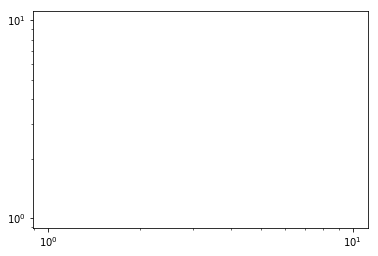

In [30]:
plt.loglog(density_array[1:],run_time[:],'-o')

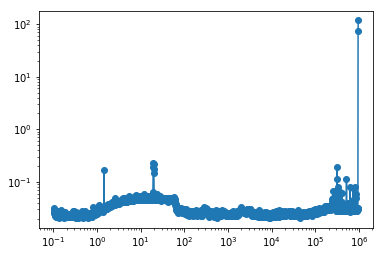

In [31]:
plt.loglog(density_array[2:],run_time[:],'-o')

In [ ]:
all_data.keys()

In [ ]:
dir_ff_grackle = "/home/kwoksun2/grackle/src/python/examples/freefall.h5"
import h5py
f = h5py.File(dir_ff_grackle)

fdata = f['data']
grackle_data = convert_from_grackle_to_dengo_all(fdata)

In [ ]:
ic = 0
from matplotlib.pyplot import cm
color=cm.tab20(np.linspace(0,1,len(all_data.keys()) ))

plt.figure(figsize=(10,10))
for key in all_data.keys():
    
    print(key)
    if key not in ['density','t','force_factor','ge','T']:
        data = numpy.array(all_data[key])
        data1 = grackle_data[key]
        print(len(data1))
        print(len(data))
        plt.semilogx( density_array[:-1], data1/density_array[:-1],c=color[ic], ls = '--')
        
        plt.loglog( density_array[:-1], data/density_array[:-1],label=key, c=color[ic])
    ic += 1
plt.legend()
plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel(r'mass density $n_x m_x / \rho$ ')

In [ ]:
plt.figure(figsize=(10,10))

H2_1 =  fdata['H2I'] 
density = numpy.array(fdata['density'])

data = numpy.array(all_data['H2_1']) / density_array[:-1]

plt.semilogx( density_array[1:]*u.amu_cgs, H2_1/density,label=key,c=color[0],ls='--')
plt.loglog( density_array[1:]*u.amu_cgs, 2.0*data*1.00794   ,label=key,c=color[0])
plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel(r'mass density $n_x m_x / \rho$ ')

In [ ]:
plt.figure(figsize=(10,10))
data0 =  fdata['temperature'] #
plt.semilogx(density, data0, label=key)

data1 = numpy.array(all_data['T']) 
plt.semilogx( density_array[1:]*u.amu_cgs, data1,label=key)

plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel('mass density  ' + r"$n_x m_x / \rho$")

In [ ]:
plt.semilogx(density,force_factor)

In [ ]:
plt.semilogx(density,force_factor)
data = numpy.array(all_data['force_factor']) 
plt.semilogx( density_array[1:]*u.amu_cgs, data,label=key)

In [ ]:
data = numpy.array(all_data['force_factor']) 
plt.loglog( density_array[1:][data>0], data[data>0],label=key)

In [ ]:
len(data)

In [ ]:
plt.loglog(density_array[1:], pressure_array)

In [ ]:
action.tables

In [ ]:
def cooling_rate_from_temp(T):
    cooling_rates = {}
    for action in primordial.cooling_actions.values():
        actionname = action.name
        for tab in action.tables:
            name = "{}_{}[i]".format(actionname, tab)
            
            temp_array = primordial.T
            
            cooling = numpy.interp(T, temp_array, action.tables[tab](primordial))
            cooling_rates[name] = cooling
    cooling_rates['T'] = T
    cooling_rates['z'] = numpy.zeros((len(T)))
#     cooling_rates = sorted(cooling_rates)
    return cooling_rates

def cooling_from_results(results, primordial, cooling_rates, T):
    
    cooling_results = {}

    for action in primordial.cooling_actions:
        cool_action = cooling_registry[action].equation
        cool_sym = cool_action.free_symbols
        
        cool_sym_name = [str(i) for i in cool_sym]
        func = lambdify(cool_sym, cool_action,'numpy') # returns a numpy-ready function
        
        
        num_var = len(cool_sym)
        len_T   = len(T)
        
        input_array = numpy.zeros(( num_var, len_T ))       
        for iii, sym_name in enumerate(cool_sym_name):
            try:
                input_array[iii, :] = results[sym_name]
            except:
                input_array[iii, :] = cooling_rates[sym_name]
        
        
        cooling_results[action] = func(*input_array)
    return cooling_results

In [ ]:
T_array = all_data['T']

cooling_rates = cooling_rate_from_temp(T_array)
cooling_rates['mdensity'] = density_array[1:]
cooling_rates['mh'] = numpy.ones((len(T_array)))* u.mass_hydrogen_cgs.v

cooling_results = cooling_from_results(all_data, primordial, cooling_rates, T_array)


T_array_gra = grackle_data['T']

cooling_rates_gra = cooling_rate_from_temp(T_array_gra)
cooling_rates_gra['mdensity'] = density_array[1:]
cooling_rates_gra['mh'] = numpy.ones((len(T_array_gra)))* u.mass_hydrogen_cgs.v

cooling_results_gra = cooling_from_results(grackle_data, primordial, cooling_rates_gra, T_array_gra)

In [ ]:
plt.figure(figsize=(10,10))
from matplotlib.pyplot import cm
color=cm.tab20(np.linspace(0,1,len(cooling_results.keys()) ))
net_cooling = numpy.zeros((len(T_array)))

iii = 0
for i in cooling_results.keys():
    d = cooling_results[i]
    
    net_cooling = d + net_cooling
    if i not in ['gammah']:
        if d[0] < 0:
            plt.semilogx(density_array[1:], numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, label=i,c=color[iii])
        else:
            plt.loglog(density_array[1:], numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, label=i,  c=color[iii])
            
    iii += 1
    
net_cooling_gra = numpy.zeros((len(T_array_gra)))

iii = 0
for i in cooling_results_gra.keys():
    d = cooling_results_gra[i]
    
    net_cooling_gra = d + net_cooling_gra
    if i not in ['gammah']:
        if d[0] < 0:
            plt.semilogx(density_array[1:], numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, label=i,ls= '--', c=color[iii])
        else:
            plt.loglog(density_array[1:], numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, label=i, ls= '--', c=color[iii])
            
    iii += 1    

plt.legend()
plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel(r'cooling rate per unit mass (erg / g /s)')
plt.ylim(1e-5,1e5)
plt.gca().set_color_cycle(None)


plt.show()

plt.figure(figsize=(10,10))
plt.loglog(density_array[1:], numpy.abs(net_cooling)/density_array[1:]/ u.amu_cgs.v)
plt.loglog(density_array[1:], numpy.abs(net_cooling_gra)/density_array[1:]/ u.amu_cgs.v,ls= '--')
plt.ylim(1e-5,1e5)
plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel(r'cooling rate per unit mass (erg / g /s)')
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
from matplotlib.pyplot import cm
color=cm.tab20(np.linspace(0,1,len(cooling_results_gra.keys()) ))
net_cooling_gra = numpy.zeros((len(T_array_gra)))

iii = 0
for i in cooling_results_gra.keys():
    d = cooling_results_gra[i]
    
    net_cooling = d + net_cooling
    if i not in ['gammah']:
        if d[0] < 0:
            plt.semilogx(density_array[1:], numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, label=i,ls= '--', c=color[iii])
        else:
            plt.loglog(density_array[1:], numpy.abs(d)/density_array[1:]/ u.amu_cgs.v, label=i, ls= '--', c=color[iii])
            
    iii += 1
plt.legend()
plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel(r'cooling rate per unit mass (erg / g /s)')
plt.show()

plt.figure(figsize=(10,10))
plt.loglog(density_array[1:], numpy.abs(net_cooling_gra)/density_array[1:]/ u.amu_cgs.v,ls= '--')
plt.xlabel('density (amu / $cm^{-3}$)')
plt.ylabel(r'cooling rate per unit mass (erg / g /s)')
plt.show()

In [ ]:
d = cooling_results['h2formation']
plt.loglog(density_array[1:], (d), label=i, ls= '--')

In [ ]:
from matplotlib.pyplot import cm
color=cm.rainbow(np.linspace(0,1,100))

In [ ]:
color[10]

In [ ]:
net_cooling

# TO-DO list

1. profile the code (run-time ~ 0.02s) no matter how
2. interpolate gammaH2 (it is calculate on the fly everytime)
3. include CIE cooling

In [ ]:
init = {}

init['apple'] = range(10)
init['bb'] = range(20)

In [ ]:
f= h5py.File('freefall_dengo_analyticgammaH2.h5')
for k,v in all_data.items():
    f.create_dataset(k,data=v)
f.create_dataset('run_time',data=run_time)
f.close()

In [ ]:
f= h5py.File('freefall_dengo_analyticgammaH2.h5')
print(f.keys())
all_data = {}
for key in f.keys():
    all_data[key] = numpy.array(f[key])
f.close()

In [ ]:
all_data

In [ ]:
primordial.temperature_calculation(derivative_dge_dT=True)


In [ ]:
sp = species_registry['H2_1']
T = primordial.T
d_dT = primordial.interpolate_species_gamma(sp, deriv=True)

In [34]:
sp = species_registry['H2_1']

In [36]:
dengo.umist_rates.umist_rates(sp, primordial)